In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


from astropy.io import fits
import dill as pickle
from emcee import EnsembleSampler
import numpy as np
import os
import sys
import math

pwd = os.getcwd()
little_things_root_dir = os.path.dirname(pwd)
sys.path.append(little_things_root_dir)

from little_things_lib.galaxy import Galaxy
from little_things_lib.nfw_mcmc_fitter import (
    EmceeParameters,
    get_mcmc_start_position, 
    generate_nwalkers_start_points, 
    lnprob)
from little_things_lib.plotting import plot_posterior_distributions, plot_walker_paths

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Enter parameters for galaxy in cell below

In [3]:
galaxy_name = 'DDO46'

DEG_PER_PIXEL = 4.17e-4
DISTANCE = 6100 # kpc

# can leave these as any number for now, not used
LUMINOSITY = 1e8  # solar luminositiy
HI_MASS = 1e8  # solar masses

In [4]:
mcmc_params = EmceeParameters(
    ndim=3,
    nwalkers=10, 
    nburn=0,
    niter=200,
    nthin=0,
    nthreads=4
)

In [5]:
"""
Expect the data to be provided in following naming convention in 'data' directory:

2D observed velocity field FITS file: <galaxy_name>_1mom.fits
Bbarolo fit parameters text file: <galaxy_name>_ring_parameters.txt
Stellar velocity curve: <galaxy_name>_stellar_velocities.txt
Gas velocity_curve: <galaxy_name>_gas_velocities.txt

"""


data_dir = os.path.join(little_things_root_dir, 'data')

observed_2d_vel_field_fits_file = os.path.join(data_dir, f'{galaxy_name}_1mom.fits')
ring_parameters_file = os.path.join(data_dir, f'{galaxy_name}_ring_parameters.txt')

stellar_velocities_file = os.path.join(data_dir, f'{galaxy_name}_stellar_velocities.txt')
gas_velocities_file = os.path.join(data_dir, f'{galaxy_name}_gas_velocities.txt')


In [6]:
radii_kpc, test_rotation_curve, inclinations, position_angles, x_centers, y_centers , v_systemics = \
    np.loadtxt(ring_parameters_file, usecols=(0,2,4,5,-4,-3,-2)).T

avg_inclination = np.mean(inclinations)
avg_position_angle = np.mean(position_angles)
avg_x_center = 75
avg_y_center = 75
x_centers = np.array([avg_x_center for i in range(len(inclinations))])
y_centers = np.array([avg_y_center for i in range(len(inclinations))])
v_systemic = np.mean(v_systemics)

observed_2d_vel_field = fits.open(observed_2d_vel_field_fits_file)[0].data

stellar_radii, stellar_vel = np.loadtxt(stellar_velocities_file, unpack=True, usecols =(0,1))
gas_radii, gas_vel = np.loadtxt(gas_velocities_file, unpack=True, usecols = (0,1))

In [7]:
galaxy = Galaxy(
    distance_to_galaxy=DISTANCE,  # [kpc] Look this up for the galaxy 
    deg_per_pixel=DEG_PER_PIXEL ,  # 'CRDELT1' and 'CRDELT2' in the FITS file header (use absolute value)
    galaxy_name=galaxy_name,
    vlos_2d_data=observed_2d_vel_field,
    output_dir='output',
    luminosity=LUMINOSITY,
    HI_mass=HI_MASS)

tilted_ring_params = {
    'v_systemic': v_systemic,
    'radii': radii_kpc,   
    'inclination': inclinations,
    'position_angle': position_angles,
    'x_pix_center': x_centers,
    'y_pix_center': y_centers
}

galaxy.set_tilted_ring_parameters(**tilted_ring_params)

galaxy.interpolate_baryonic_rotation_curve(
    baryon_type='stellar',
    rotation_curve_radii=stellar_radii,
    rotation_curve_velocities=stellar_vel)

galaxy.interpolate_baryonic_rotation_curve(
    baryon_type='gas',
    rotation_curve_radii=gas_radii,
    rotation_curve_velocities=gas_vel)

# initialize MCMC start position and bounds
galaxy.set_nfw_prior_bounds(
    rhos_bounds=(1e6, 1e9),   # msun / kpc^3
    rs_bounds=(0.1, 10),  # kpc
    ml_bounds=(0.1, 10),
  
)

In [8]:
v=galaxy.create_2d_velocity_field(
    tilted_ring_params['radii'], 
    v_rot = test_rotation_curve  
)

In [9]:
galaxy.radii/galaxy.kpc_per_pixel

array([ 0.69826205,  2.11731072,  3.51383481,  4.93288348,  6.32940757,
        7.74845625,  9.14498034, 10.56402901, 11.9605531 , 13.35707719,
       14.77612586, 16.17264995, 17.59169863, 18.98822272, 20.40727139,
       21.80379548, 23.22284416, 24.61936825, 26.03841692, 27.43494101,
       28.85398968, 30.25051377, 31.66956245, 33.06608654, 34.48513521,
       35.8816593 , 37.30070797, 38.69723206, 40.09375616, 41.51280483,
       42.90932892, 44.32837759, 45.72490168, 47.14395036, 48.54047445,
       49.95952312, 51.35604721, 52.77509588, 54.17161997, 55.59066865,
       56.98719274, 58.40624141, 59.8027655 , 61.22181417, 62.61833827,
       64.03738694, 65.43391103, 66.83043512, 68.24948379, 69.64600788])

In [10]:
# This will print warnings if the start points go outside prior bounds

start_point, start_point_radii = get_mcmc_start_position(galaxy)
start_pos = generate_nwalkers_start_points(galaxy, mcmc_params.nwalkers, start_point, start_point_radii)

In [11]:
sampler = EnsembleSampler(
    mcmc_params.nwalkers,
    mcmc_params.ndim, 
    lnprob, 
    args=[galaxy], 
    threads=mcmc_params.nthreads)

# this will break up the fitting procedure into smaller chunks of size batch_size and save progress

batch_size = 20
mcmc_output = []
for batch in range(mcmc_params.niter // batch_size):
    if batch== 0:
        batch_start = start_pos 
    else:
        batch_start = None
        sampler.pool = temp_pool
    mcmc_output += sampler.run_mcmc(batch_start, batch_size)
    temp_pool = sampler.pool
    del sampler.pool
    with open('sampler.pkl', 'wb') as f:
        pickle.dump(sampler, f)
    with open('mcmc_output.pkl', 'wb') as f:
        pickle.dump(mcmc_output, f)
    print(f"Done with steps {batch*batch_size} - {(batch+1)*batch_size} out of {mcmc_params.niter}")


Done with steps 0 - 20 out of 200
Done with steps 20 - 40 out of 200
Done with steps 40 - 60 out of 200
Done with steps 60 - 80 out of 200
Done with steps 80 - 100 out of 200
Done with steps 100 - 120 out of 200
Done with steps 120 - 140 out of 200
Done with steps 140 - 160 out of 200
Done with steps 160 - 180 out of 200
Done with steps 180 - 200 out of 200


In [12]:
# example of how to load the pickled objects
with open('sampler.pkl', 'rb') as f:
    sampler = pickle.load(f)
with open('mcmc_output.pkl', 'rb') as f:
    mcmc_output = pickle.load(f)

#### Plot the posterior distributions and walker paths

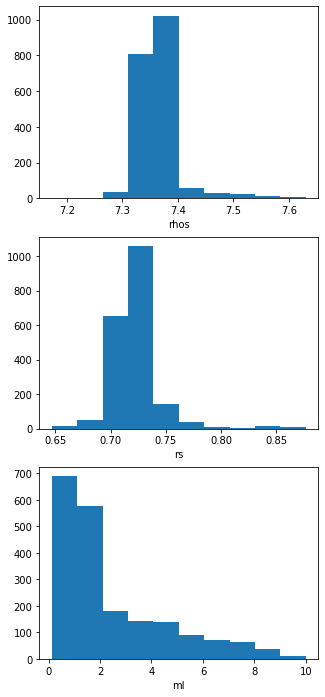

rhos: 7.365168279983351 +/- 0.037368994169616476
rs: 0.7230073699687624 +/- 0.02283398201387238
ml: 2.409914814969058 +/- 2.132474954084403


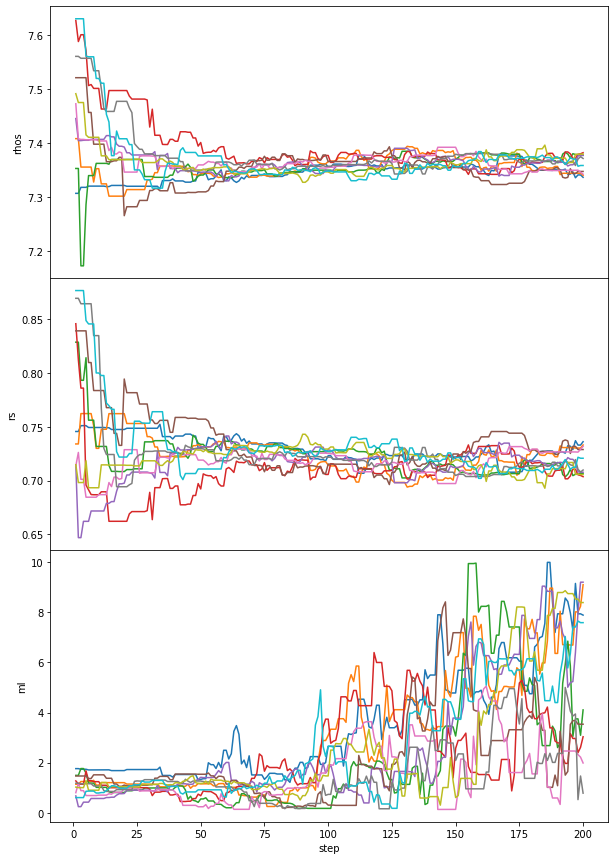

In [13]:
plot_posterior_distributions(sampler, labels=['rhos', 'rs', 'ml'])

plot_walker_paths(
    sampler,
    mcmc_params,
    labels=['rhos', 'rs', 'ml'])

def get_fit_stats(sampler, labels=["rhos", "rs", "ml"]):
    for i, label in enumerate(labels):
        chain = sampler.chain[:, :, i].flatten()
        print(f"{label}: {np.mean(chain)} +/- {np.std(chain)}")
        
get_fit_stats(sampler)

#### Compare observed 2d velocity field with one generated during fitting process

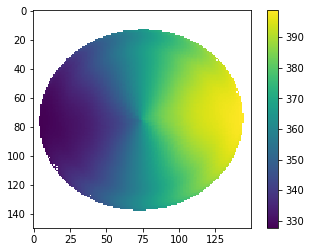

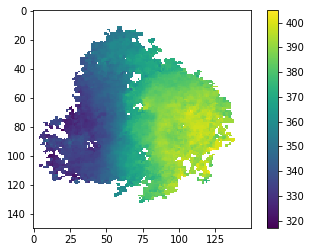

In [14]:
example_2d_field = mcmc_output[-1][9][-1]
plt.imshow(example_2d_field)
plt.colorbar()
plt.show()

plt.imshow(galaxy.vlos_2d_data)
plt.colorbar()
plt.show()


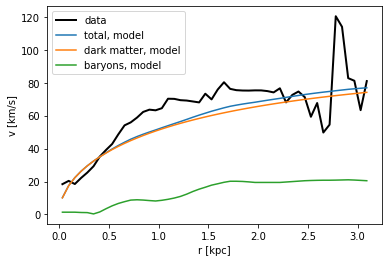

In [15]:
blobs = np.reshape(sampler.blobs, (mcmc_params.niter * mcmc_params.nwalkers,10))
v_dm = np.mean( blobs[:, 4])
v_baryon = np.mean( blobs[:, 5])
v_tot = np.mean( blobs[:, 7])

plt.plot(radii_kpc, test_rotation_curve, linewidth=2., label="data", color="black")

plt.plot(galaxy.radii, v_tot, label="total, model")
plt.plot(galaxy.radii, v_dm, label="dark matter, model")
plt.plot(galaxy.radii, v_baryon, label="baryons, model")
plt.xlabel("r [kpc]")
plt.ylabel("v [km/s]")
plt.legend()

In [16]:
#From NFW-Model
rhos = 7.458491004337313
rs = 0.6592991031341774

G=4.301e-6 #units of kpc km^2 M_solar^-1 s^-2

#From Little-Things paper
vmax=66.1 #units of km/s
rmax = 2.92

rhos_calculated=vmax**2/(4*math.pi*G*math.pow((rmax/2.16),2)) #units Solar Masses per kpc^3
Err_rhos=(rhos_calculated-rhos)/rhos_calculated

rs_calculated = rmax/2.16
Err_rs = (rs_calculated - rs)/rs_calculated

In [17]:
Err_rhos, Err_rs

(0.9999998313891342, 0.5122992935719783)

In [18]:
Vmax = np.sqrt(0.216*4*np.pi*G*rhos*(rs)**2)
Rmax = 2.16*rs

print("NFW Fit Vmax:",Vmax,"\n","NFW Fit Rmax:", Rmax)

NFW Fit Vmax: 0.006152115763868518 
 NFW Fit Rmax: 1.4240860627698233


In [19]:
vmax_err = (v_max - Vmax)/v_max
rmax_err = (rmax-Rmax)/rmax

print("Vmax Error:",vmax_err,"\n","Rmax Error:", rmax_err)

NameError: name 'v_max' is not defined